# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)
    train_feats = [var for x in train_feats for var in train_feats[x]]

In [3]:
n_models = 10
patience = 10
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"), rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


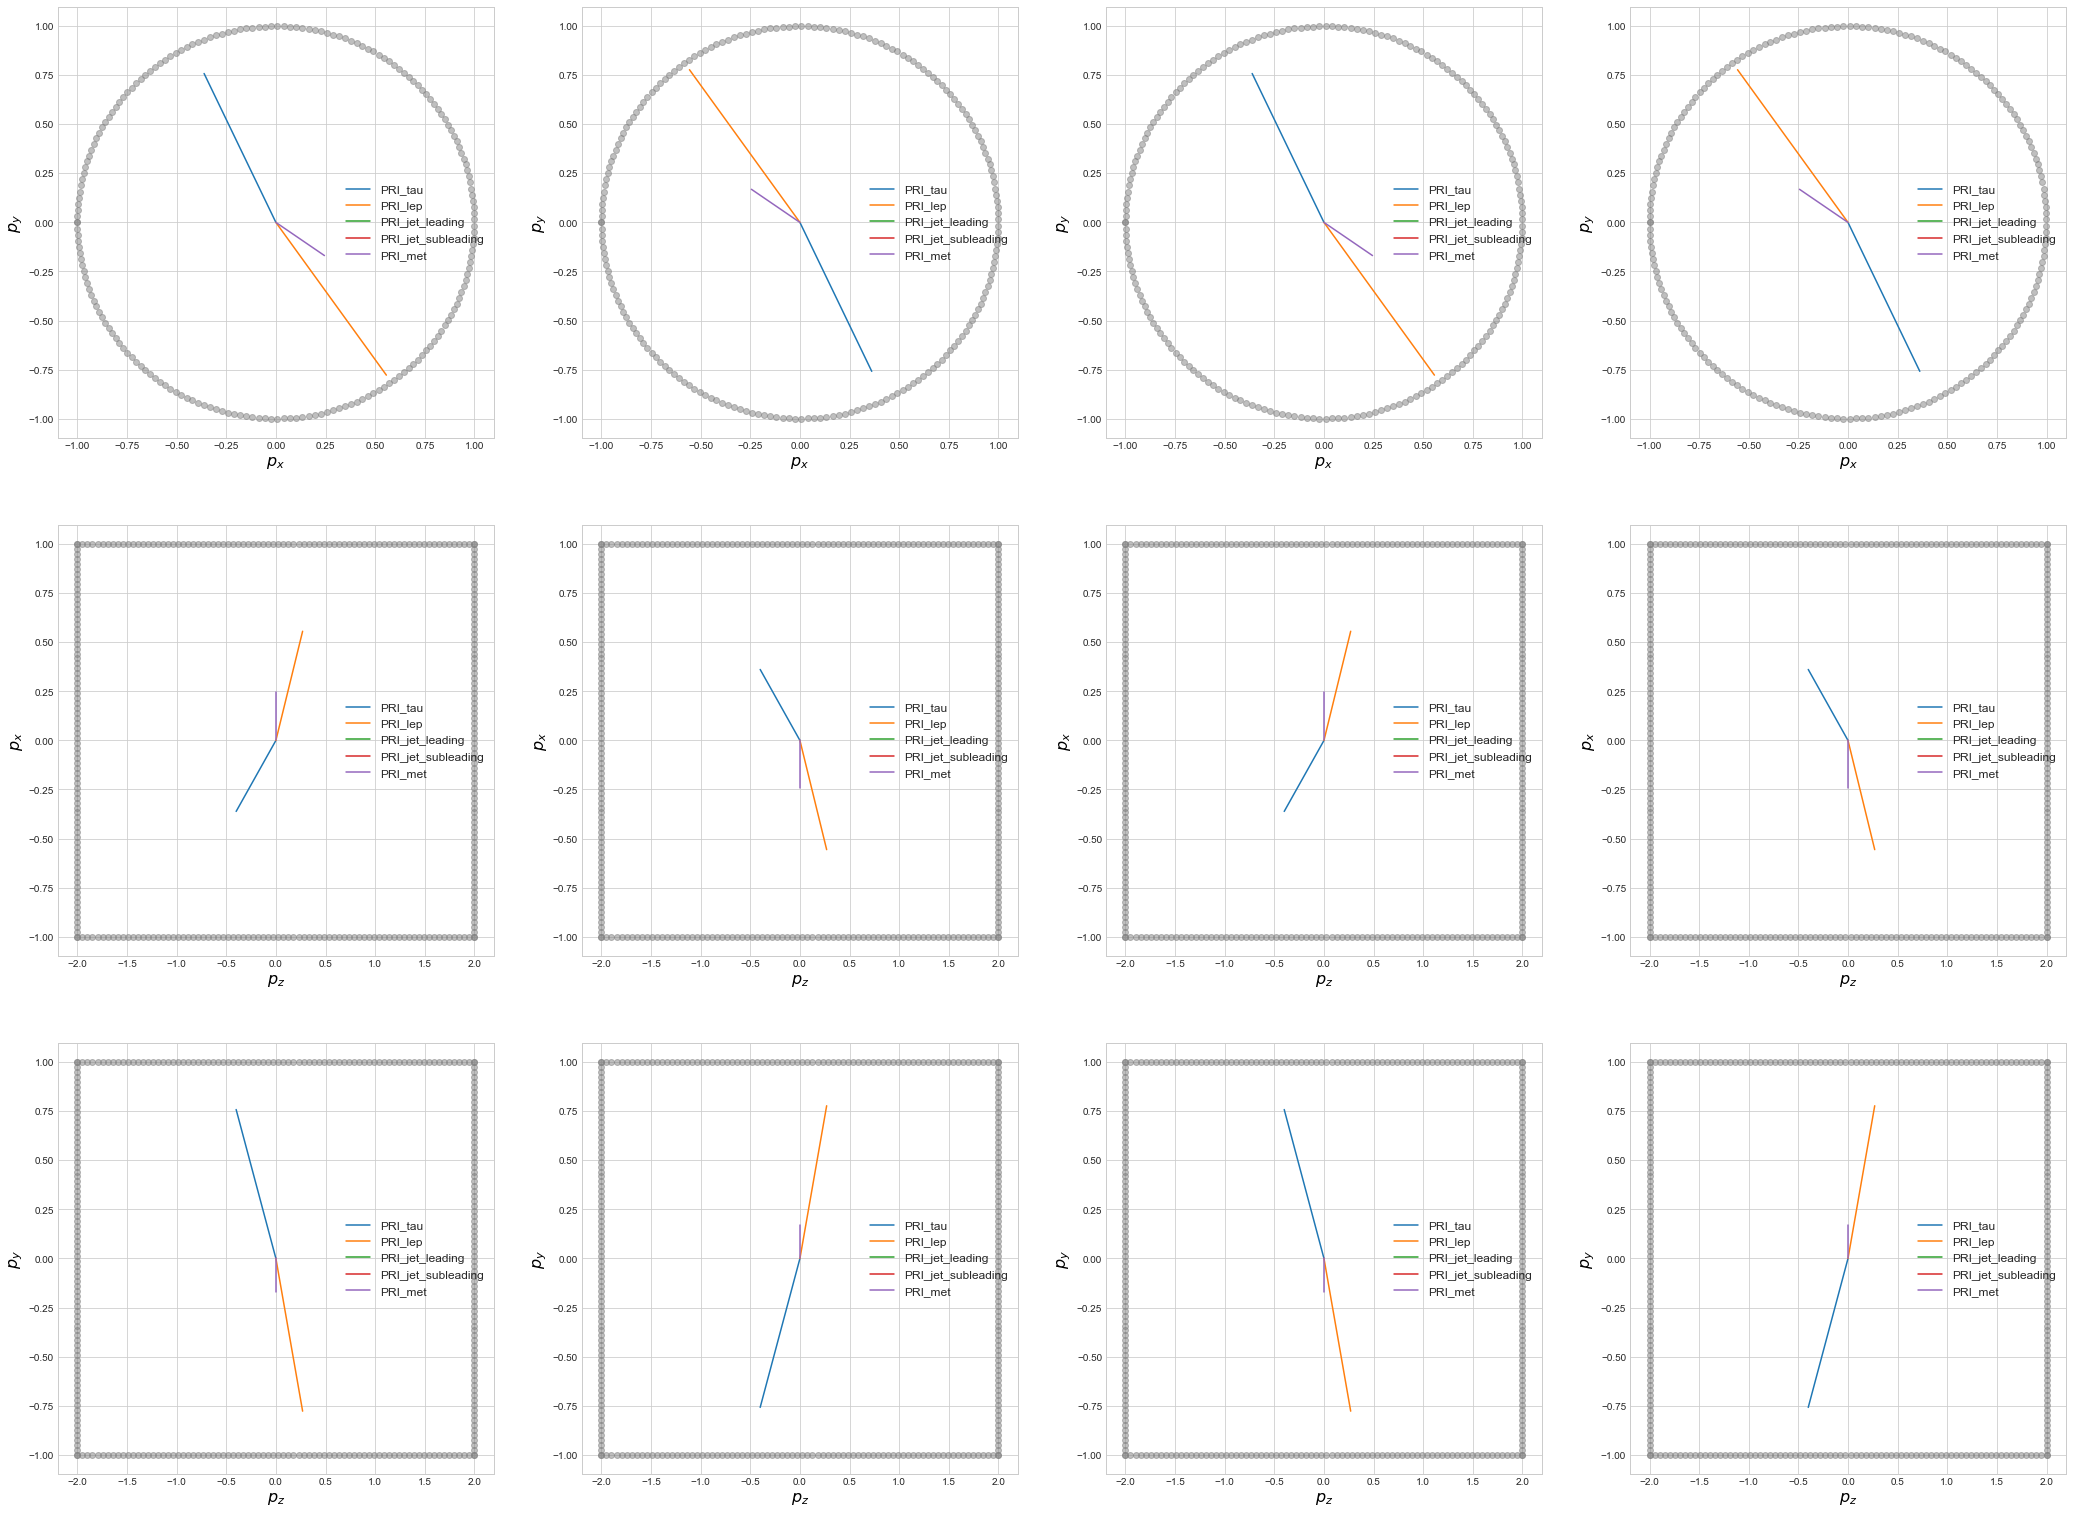

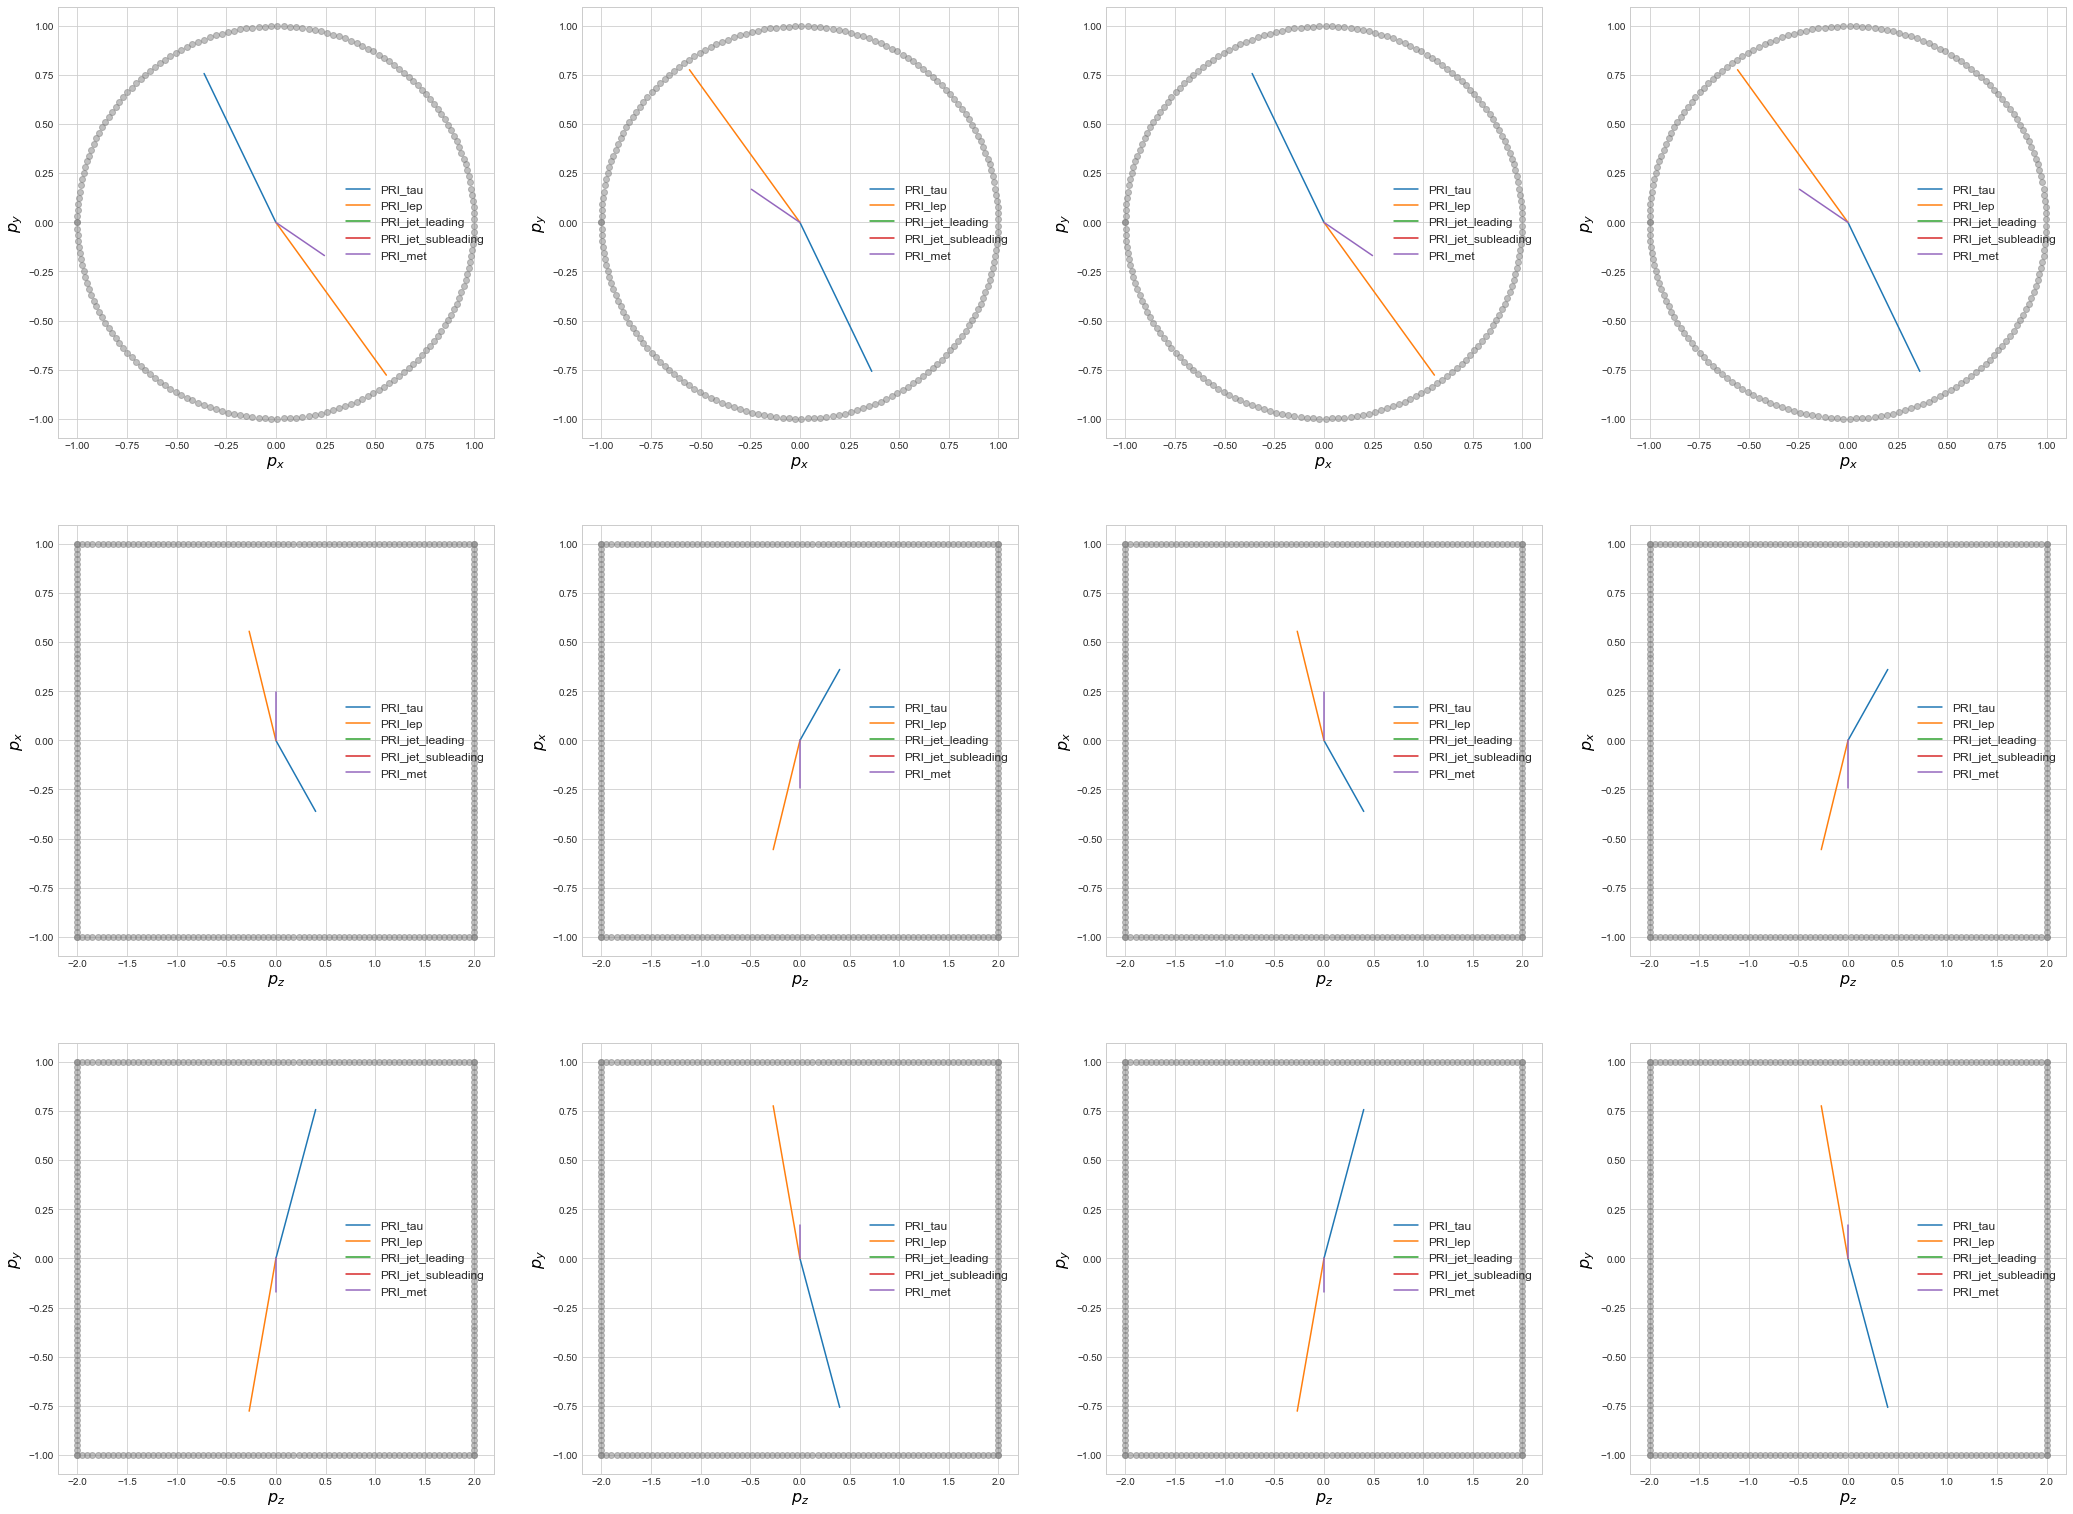

In [5]:
id=3
aug_ranges = [range(4), range(4,8)]
for aug_range in aug_ranges:
    comp_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

## Determine LR

2 classes found, running in binary mode



/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 11.551s 


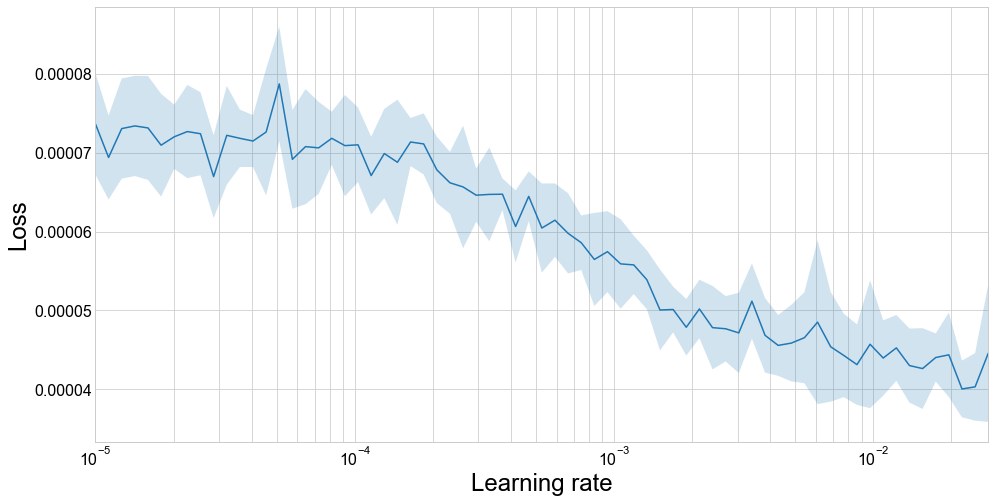

______________________________________



In [6]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [7]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'LinearCLR':{'reverse':False, 'max_lr':2e-3, 'min_lr':2e-4, 'scale':2},
                 'SWA':{'renewal':5, 'sgd_replacement':False, 'start':1},}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using linear LR cycle
2 classes found, running in binary mode

1 New best found: 4.136152711162148e-05
2 New best found: 3.7873943724276366e-05
3 New best found: 3.685447523089588e-05
SWA beginning
model is 0 epochs old
4 swa loss 3.519588674060838e-05, default loss 3.519588674060838e-05
Saving snapshot 1
4 New best found: 3.519588674060838e-05
5 swa loss 3.519588674060838e-05, default loss 3.5117940348561966e-05
5 New best found: 3.5117940348561966e-05
6 swa loss 3.519588674060838e-05, default loss 3.460033869317695e-05
6 New best found: 3.460033869317695e-05
7 swa loss 3.519588674060838e-05, default loss 3.410838664707276e-05
7 New best found: 3.410838664707276e-05
model is 1 epochs old
8 swa loss 3.410139657221655e-05, default loss 3.367197611443171e-05
Saving snapshot 2
8 New best found: 3.367197611443171e-05
9 swa loss 3.410139657221655e-05, default loss 3.36911341759687e-05
10 swa loss 3.410139657221655e-05, default loss 3.455078052961

84 swa loss 3.1677190243727105e-05, default loss 3.178205965651373e-05
Saving snapshot 21
84 New best found: 3.1677190243727105e-05
85 swa loss 3.1677190243727105e-05, default loss 3.198892166885048e-05
85 New best found: 3.1677190243727105e-05
86 swa loss 3.1677190243727105e-05, default loss 3.239763602457613e-05
86 New best found: 3.1677190243727105e-05
87 swa loss 3.1677190243727105e-05, default loss 3.2134210056692913e-05
87 New best found: 3.1677190243727105e-05
model is 11 epochs old
new model is 1 epochs old
88 swa loss 3.1659601942304395e-05, default loss 3.1836993303856205e-05
Saving snapshot 22
88 New best found: 3.1659601942304395e-05
89 swa loss 3.1659601942304395e-05, default loss 3.1845663034473575e-05
89 New best found: 3.1659601942304395e-05
90 swa loss 3.1659601942304395e-05, default loss 3.24108372437611e-05
90 New best found: 3.1659601942304395e-05
91 swa loss 3.1659601942304395e-05, default loss 3.207831174007686e-05
91 New best found: 3.1659601942304395e-05
model i

144 swa loss 3.134653183889201e-05, default loss 3.1552922227951055e-05
Saving snapshot 36
144 New best found: 3.134653183889201e-05
145 swa loss 3.134653183889201e-05, default loss 3.1779053513894645e-05
145 New best found: 3.134653183889201e-05
146 swa loss 3.134653183889201e-05, default loss 3.214528266112502e-05
146 New best found: 3.134653183889201e-05
147 swa loss 3.134653183889201e-05, default loss 3.189321757215874e-05
147 New best found: 3.134653183889201e-05
model is 6 epochs old
new model is 1 epochs old
148 swa loss 3.133603666368254e-05, default loss 3.164905907235417e-05
Saving snapshot 37
148 New best found: 3.133603666368254e-05
149 swa loss 3.133603666368254e-05, default loss 3.1686099468688766e-05
149 New best found: 3.133603666368254e-05
150 swa loss 3.133603666368254e-05, default loss 3.205437931759574e-05
150 New best found: 3.133603666368254e-05
151 swa loss 3.133603666368254e-05, default loss 3.172654143541956e-05
151 New best found: 3.133603666368254e-05
model i

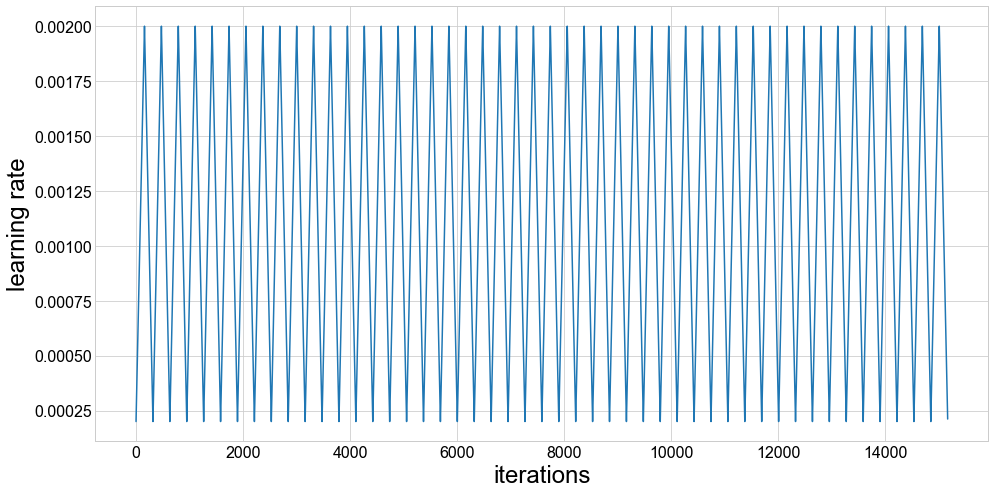

Fold took 178.960s

Training model 2 / 10
Using linear LR cycle


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109274). Check your callbacks.
  % delta_t_median)


1 New best found: 4.3049828040898104e-05
2 New best found: 4.240210630544595e-05
3 New best found: 3.672049502659959e-05
SWA beginning
model is 0 epochs old
4 swa loss 3.621494244157185e-05, default loss 3.621494244157185e-05
Saving snapshot 1
4 New best found: 3.621494244157185e-05
5 swa loss 3.621494244157185e-05, default loss 3.645157403822142e-05
5 New best found: 3.621494244157185e-05
6 swa loss 3.621494244157185e-05, default loss 3.688791708751695e-05
6 New best found: 3.621494244157185e-05
7 swa loss 3.621494244157185e-05, default loss 3.6099512814219164e-05
7 New best found: 3.6099512814219164e-05
model is 1 epochs old
8 swa loss 3.543583969960299e-05, default loss 3.516726835828867e-05
Saving snapshot 2
8 New best found: 3.516726835828867e-05
9 swa loss 3.543583969960299e-05, default loss 3.5436434788208133e-05
10 swa loss 3.543583969960299e-05, default loss 3.605553454609757e-05
11 swa loss 3.543583969960299e-05, default loss 3.5319774227016155e-05
model is 2 epochs old
12 sw

84 swa loss 3.3676548365650144e-05, default loss 3.386063060340474e-05
Saving snapshot 21
84 New best found: 3.3676548365650144e-05
85 swa loss 3.3676548365650144e-05, default loss 3.4261176272908944e-05
85 New best found: 3.3676548365650144e-05
86 swa loss 3.3676548365650144e-05, default loss 3.467532306521402e-05
86 New best found: 3.3676548365650144e-05
87 swa loss 3.3676548365650144e-05, default loss 3.431825667997761e-05
87 New best found: 3.3676548365650144e-05
model is 11 epochs old
new model is 1 epochs old
88 swa loss 3.3663628890024136e-05, default loss 3.3876540407648595e-05
Saving snapshot 22
88 New best found: 3.3663628890024136e-05
89 swa loss 3.3663628890024136e-05, default loss 3.420276601926547e-05
89 New best found: 3.3663628890024136e-05
90 swa loss 3.3663628890024136e-05, default loss 3.436716043395287e-05
90 New best found: 3.3663628890024136e-05
91 swa loss 3.3663628890024136e-05, default loss 3.449875190038446e-05
91 New best found: 3.3663628890024136e-05
model i

model is 16 epochs old
new model is 6 epochs old
148 swa loss 3.352185734484304e-05, default loss 3.385574770408572e-05
Saving snapshot 37
148 New best found: 3.352185734484304e-05
149 swa loss 3.352185734484304e-05, default loss 3.370477683255437e-05
149 New best found: 3.352185734484304e-05
150 swa loss 3.352185734484304e-05, default loss 3.470556072088306e-05
150 New best found: 3.352185734484304e-05
151 swa loss 3.352185734484304e-05, default loss 3.4357064420813597e-05
151 New best found: 3.352185734484304e-05
model is 17 epochs old
new model is 7 epochs old
152 swa loss 3.3519497804032075e-05, default loss 3.382412449928728e-05
Saving snapshot 38
152 New best found: 3.3519497804032075e-05
153 swa loss 3.3519497804032075e-05, default loss 3.3644105658407735e-05
153 New best found: 3.3519497804032075e-05
154 swa loss 3.3519497804032075e-05, default loss 3.418563803991093e-05
154 New best found: 3.3519497804032075e-05
155 swa loss 3.3519497804032075e-05, default loss 3.3734183236391

214 swa loss 3.3367465958090845e-05, default loss 3.416828116320675e-05
214 New best found: 3.3367465958090845e-05
215 swa loss 3.3367465958090845e-05, default loss 3.389825863589378e-05
215 New best found: 3.3367465958090845e-05
model is 23 epochs old
new model is 8 epochs old
216 swa loss 3.33650800176967e-05, default loss 3.3615831103535326e-05
Saving snapshot 54
216 New best found: 3.33650800176967e-05
217 swa loss 3.33650800176967e-05, default loss 3.378521812437954e-05
217 New best found: 3.33650800176967e-05
218 swa loss 3.33650800176967e-05, default loss 3.3965428148078844e-05
218 New best found: 3.33650800176967e-05
219 swa loss 3.33650800176967e-05, default loss 3.3798684235838626e-05
219 New best found: 3.33650800176967e-05
model is 24 epochs old
new model is 9 epochs old
220 swa loss 3.336550874179451e-05, default loss 3.383506149572595e-05
Saving snapshot 55
221 swa loss 3.336550874179451e-05, default loss 3.356535087076746e-05
222 swa loss 3.336550874179451e-05, default l

293 swa loss 3.336024527614715e-05, default loss 3.3798257742017274e-05
294 swa loss 3.336024527614715e-05, default loss 3.3951905910096986e-05
295 swa loss 3.336024527614715e-05, default loss 3.396693139153968e-05
model is 43 epochs old
new model is 3 epochs old
296 swa loss 3.336268371478226e-05, default loss 3.3933135237793486e-05
Saving snapshot 74
297 swa loss 3.336268371478226e-05, default loss 3.3826054416503995e-05
298 swa loss 3.336268371478226e-05, default loss 3.415025723730087e-05
299 swa loss 3.336268371478226e-05, default loss 3.383800156303531e-05
model is 44 epochs old
new model is 4 epochs old
300 swa loss 3.33623217309913e-05, default loss 3.3755378365082725e-05
Saving snapshot 75
301 swa loss 3.33623217309913e-05, default loss 3.3993273641152216e-05
302 swa loss 3.33623217309913e-05, default loss 3.4330106921197846e-05
303 swa loss 3.33623217309913e-05, default loss 3.4023462309395365e-05
model is 45 epochs old
new model is 5 epochs old
304 swa loss 3.336170085485663

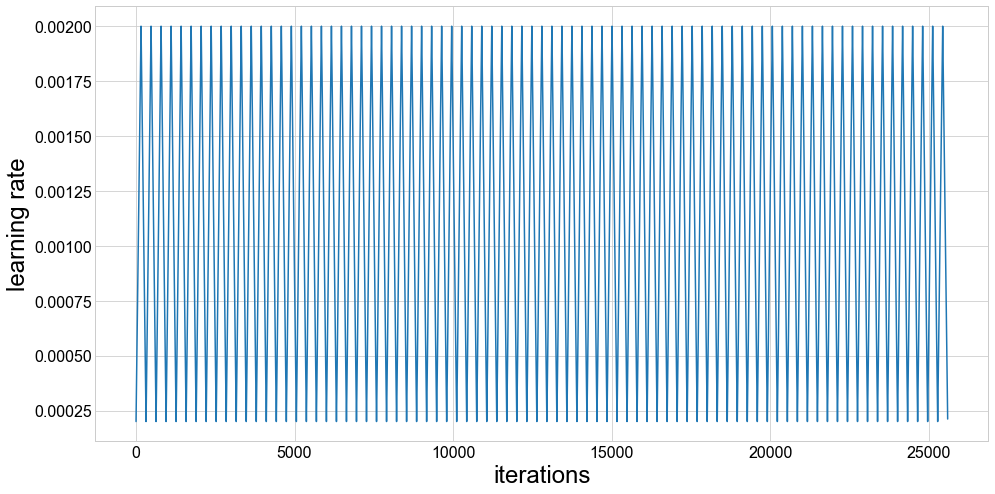

Fold took 327.434s

Training model 3 / 10
Using linear LR cycle


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119062). Check your callbacks.
  % delta_t_median)


1 New best found: 4.090570257569087e-05
2 New best found: 3.824962836069332e-05
3 New best found: 3.665362785472887e-05
SWA beginning
model is 0 epochs old
4 swa loss 3.574511746836412e-05, default loss 3.574511746836412e-05
Saving snapshot 1
4 New best found: 3.574511746836412e-05
5 swa loss 3.574511746836412e-05, default loss 3.634937732190211e-05
5 New best found: 3.574511746836412e-05
6 swa loss 3.574511746836412e-05, default loss 3.61231042483654e-05
6 New best found: 3.574511746836412e-05
7 swa loss 3.574511746836412e-05, default loss 3.529125010105214e-05
7 New best found: 3.529125010105214e-05
model is 1 epochs old
8 swa loss 3.488098472506438e-05, default loss 3.46508245761682e-05
Saving snapshot 2
8 New best found: 3.46508245761682e-05
9 swa loss 3.488098472506438e-05, default loss 3.4759447364544834e-05
10 swa loss 3.488098472506438e-05, default loss 3.567295577383127e-05
11 swa loss 3.488098472506438e-05, default loss 3.47122591800669e-05
model is 2 epochs old
12 swa loss 3

86 swa loss 3.2352081729957496e-05, default loss 3.272974386873294e-05
86 New best found: 3.2352081729957496e-05
87 swa loss 3.2352081729957496e-05, default loss 3.251806478231897e-05
87 New best found: 3.2352081729957496e-05
model is 11 epochs old
new model is 1 epochs old
88 swa loss 3.23280676788924e-05, default loss 3.244431849637103e-05
Saving snapshot 22
88 New best found: 3.23280676788924e-05
89 swa loss 3.23280676788924e-05, default loss 3.253051086615165e-05
89 New best found: 3.23280676788924e-05
90 swa loss 3.23280676788924e-05, default loss 3.275748671819459e-05
90 New best found: 3.23280676788924e-05
91 swa loss 3.23280676788924e-05, default loss 3.2989152616771995e-05
91 New best found: 3.23280676788924e-05
model is 12 epochs old
new model is 2 epochs old
92 swa loss 3.2311290244282096e-05, default loss 3.25085418678652e-05
Saving snapshot 23
92 New best found: 3.2311290244282096e-05
93 swa loss 3.2311290244282096e-05, default loss 3.2765909927140474e-05
93 New best found

146 swa loss 3.199391199304935e-05, default loss 3.2633384646334326e-05
146 New best found: 3.199391199304935e-05
147 swa loss 3.199391199304935e-05, default loss 3.2485884510731095e-05
147 New best found: 3.199391199304935e-05
model is 11 epochs old
new model is 1 epochs old
148 swa loss 3.1975527130299085e-05, default loss 3.215294428716284e-05
Saving snapshot 37
148 New best found: 3.1975527130299085e-05
149 swa loss 3.1975527130299085e-05, default loss 3.227974047954381e-05
149 New best found: 3.1975527130299085e-05
150 swa loss 3.1975527130299085e-05, default loss 3.243565507507767e-05
150 New best found: 3.1975527130299085e-05
151 swa loss 3.1975527130299085e-05, default loss 3.261644182540323e-05
151 New best found: 3.1975527130299085e-05
model is 12 epochs old
new model is 2 epochs old
152 swa loss 3.1975797304008065e-05, default loss 3.2336107328523907e-05
Saving snapshot 38
153 swa loss 3.1975797304008065e-05, default loss 3.230842075272254e-05
154 swa loss 3.1975797304008065

In [ ]:
results, histories, cycle_losses = fold_train_model(train_fy, n_models,
                                                    model_gen_params=model_gen_params,
                                                    train_params=train_params, train_on_weights=True,
                                                    use_callbacks=use_callbacks, ams_args=ams_args,
                                                    max_epochs=max_epochs, patience=patience,
                                                    verbose=1, plots=plots)

## Construct ensemble

In [ ]:
with open('train_weights/results_file.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [ ]:
%%capture --no-stdout
ensemble, weights = assemble_ensemble(results, ensemble_size, metric=ensemble_mode)

## Response on validation data without TTA

In [ ]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [ ]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

In [ ]:
val_df = convert_to_df(val_fy.source)

In [ ]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

In [ ]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

In [ ]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

## Response on validation data with TTA

In [ ]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), rot_mult=2)

In [ ]:
fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

In [ ]:
val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')

In [ ]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class),
                                                           roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class, sample_weight=val_df_tta.gen_weight)))

In [ ]:
%%time
cut_kde_tta = kde_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

In [ ]:
%%time
cut_mean_tta = mean_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [ ]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [ ]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

In [ ]:
score_test_data(test_fy.source, cut_kde)

In [ ]:
score_test_data(test_fy.source, cut_mean)

# Test scoring - With TTA

In [ ]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"), rot_mult=2)

In [ ]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

In [ ]:
score_test_data(test_fy.source, cut_kde_tta, pred_name='pred_TTA')

In [ ]:
score_test_data(test_fy.source, cut_mean_tta, pred_name='pred_TTA')

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)